<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Regularization

---

### Learning Objectives 
- Learn about regularization for regression models
- Understand how regularization modifies the loss function
- Understand the effect of regularization on coefficients
- Implement and visualize the penalties using sklearn

### Lesson Guide
- [Overview of regularization](#intro)
- [Review: the least-squares loss function](#lsq-loss)
- [The Lasso penalty](#lasso)
- [What is the effect of regularization](#effect)
- [Standardizing predictors is required](#standardization)
- [Visualizing the Lasso](#viz-lasso)
- [Model performance with complex predictor matrix using regularization](#model-performance)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id='intro'></a>

## Overview of regularization

---
### The goal of regularisation

The goal of "regularizing" regression models is to structurally prevent overfitting, "learning too much noise", by imposing a penalty on the coefficients of the model.

Regularization artificially discourages complex or extreme explanations of the world even if they fit the what has been observed better. The idea is that such explanations are unlikely to generalize well to the future.

Regularization methods like the Ridge and **Lasso** add this additional "penalty" on the size of coefficients to the loss function. When the loss function is minimized, this additional component is added to the residual sum of squares.

In other words, the minimization becomes a balance between the error between predictions and true values and the size of the coefficients. 

The two most common types of regularization are the **Lasso**, **Ridge**. There is a mixture of them called the **Elastic Net**. We will take a look at the mathematics of regularization and the effect these penalties have on model fits.




### High dimensionality

Provided that the true relationship between the response and the predictors is **approximately linear**, the least squares estimates will have **low bias**. 

If **n >> p**, where n is the number of observations and p is the number of features,then the least squares estimates tend to also have **low variance**, and hence they will perform well on the test observations.

However, **if n is not much larger than p**, then there can be a lot of variability in the least squares fit, resulting in **overfitting** and poor test performance.

By constraining or shrinking the estimated coefficients, we can often substantially reduce the variance of our model at the cost of a negligible increase in bias.

As a **bonus**, if that shrinkage can take the coefficients to zero, then we can also reduce the model complexity and make inference easier. 

### Collinearity

Colinearity refers to the situation in which two or more predictor variables are closely related to one another. 

The presence of collinearity can pose problems in the regression context, since it can be difficult to separate out the individual effects of collinear variables on the target.

In the context of high dimensionality, the problem of collinearity can grow to extreme levels, in which we can't really know which variables explain the target.

The side effect of high collinearity in our models is that we tend to overestimate the effect of particular features, and hence the coefficient values tend to be bigger.
Regularisation can help by reducing the dimensionality of the feature space and also by shriking the coefficient values.

We can no longer interpret a coefficient on a variable as the effect on the target of a one unit increase in that variable holding the other variables constant. This is because when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.

**The Lasso is particularly useful when you have redundant or unimportant variables.** If you have 1000 variables in a dataset the Lasso can perform "feature selection" automatically for you by forcing coefficients to be zero.

### When should we use regularisation?

Regularisation is an appropiate tool to get better model performance in two main instances:

- In the presence of a low ratio of dimensions to rows, where n >> p is not true.

- In the presence of high collinearity (or multicollinearity).

<a id='lsq-loss'></a>

## Review: least squares loss function

---

Ordinary least squares regression minimizes the residual sum of squares (RSS) to fit the data:

### $$ \text{minimize:}\; RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 $$

Where our model predictions for $y$ are based on the sum of the $beta_0$ intercept and the products of $\beta_i$ with $x_i$.

Alternatively, in matrix notation using predictor matrix $X$, residual errors $\epsilon$ and vector of beta coefficients $\beta$:

### $$ \text{minimize:}\; RSS = \epsilon' \epsilon = (y - \beta X)' (y - \beta X) $$

<a id='lasso'></a>

## The Lasso penalty

---

The Lasso regression adds the sum of the _absolute values_ of the $\beta$ coefficients:

### $$ \text{minimize:}\; RSS + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j|$$

**Where:**

$|\beta_j|$ is the absolute value of the $\beta$ coefficient for variable $x_j$

$\lambda_1$ is the strength of the regularization penalty component in the loss function. In lasso the lambda is denoted with a 1, in ridge the lambda is denoted with a 2.


**In matrix format the Lasso PRSS is:**

### $$ \text{Lasso PRSS} = (y - \beta X)' (y - \beta X) + \lambda_1 \; ||\beta|| $$

There is not a closed-form solution for the Lasso beta coefficients.


**Note**: A value of lambda/alpha of zero makes the problem equal to solving a "normal" Linear Regression.

<a id='effect'></a>

## What is the effect of regularization?

---

**To demonstrate the effects we will be using a dataset on wine quality.**

We will create a spurious feature matrix, with higher dimensionality and high levels of collinearity. We will see that under that context using Lasso regression will improve the generalisable power over a "vanilla" Linear Regression.



### Load the wine csv

This version has red and white wines concatenated together and tagged with a binary 1,0 indicator (1 is red wine). There are many other variables purportedly related to the rated quality of the wine.

In [2]:
wine = pd.read_csv('winequality_merged.csv')

# replace spaces in column names and convert all columns to lowercase:
wine.columns = [x.lower().replace(' ','_') for x in wine.columns]

In [3]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


**Look at the correlation between variables.**

In [4]:
wine_corr = wine.corr()
wine_corr

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
fixed_acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,0.486740
volatile_acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,0.653036
citric_acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,-0.187397
residual_sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,-0.348821
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,0.512678
free_sulfur_dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,-0.471644
total_sulfur_dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,-0.700357
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,0.390645
ph,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,0.329129
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,0.487218


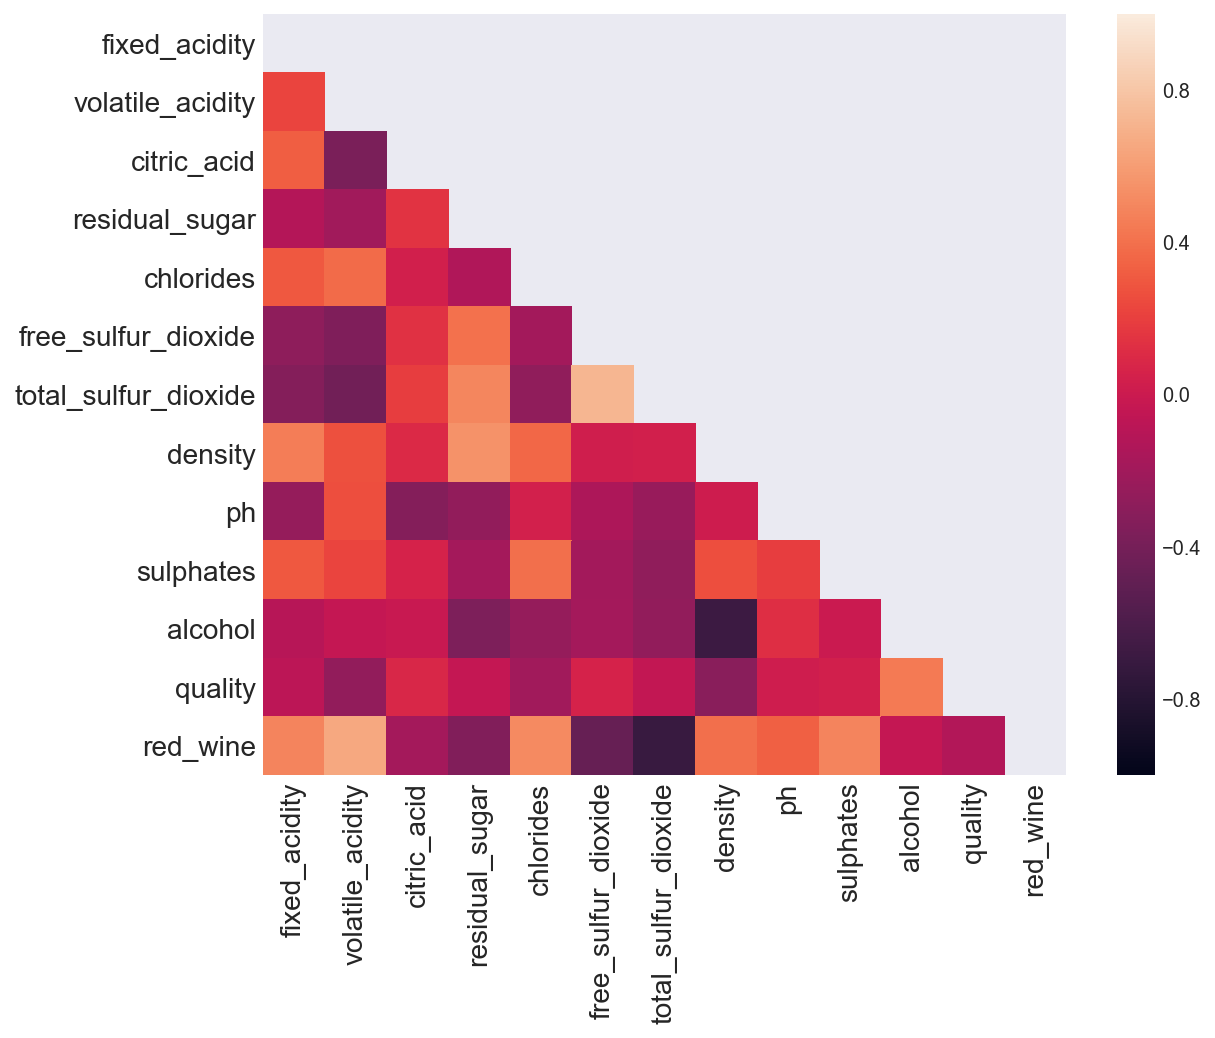

In [5]:
# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(wine_corr, mask=mask, ax=ax, vmin=-1, vmax=1)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

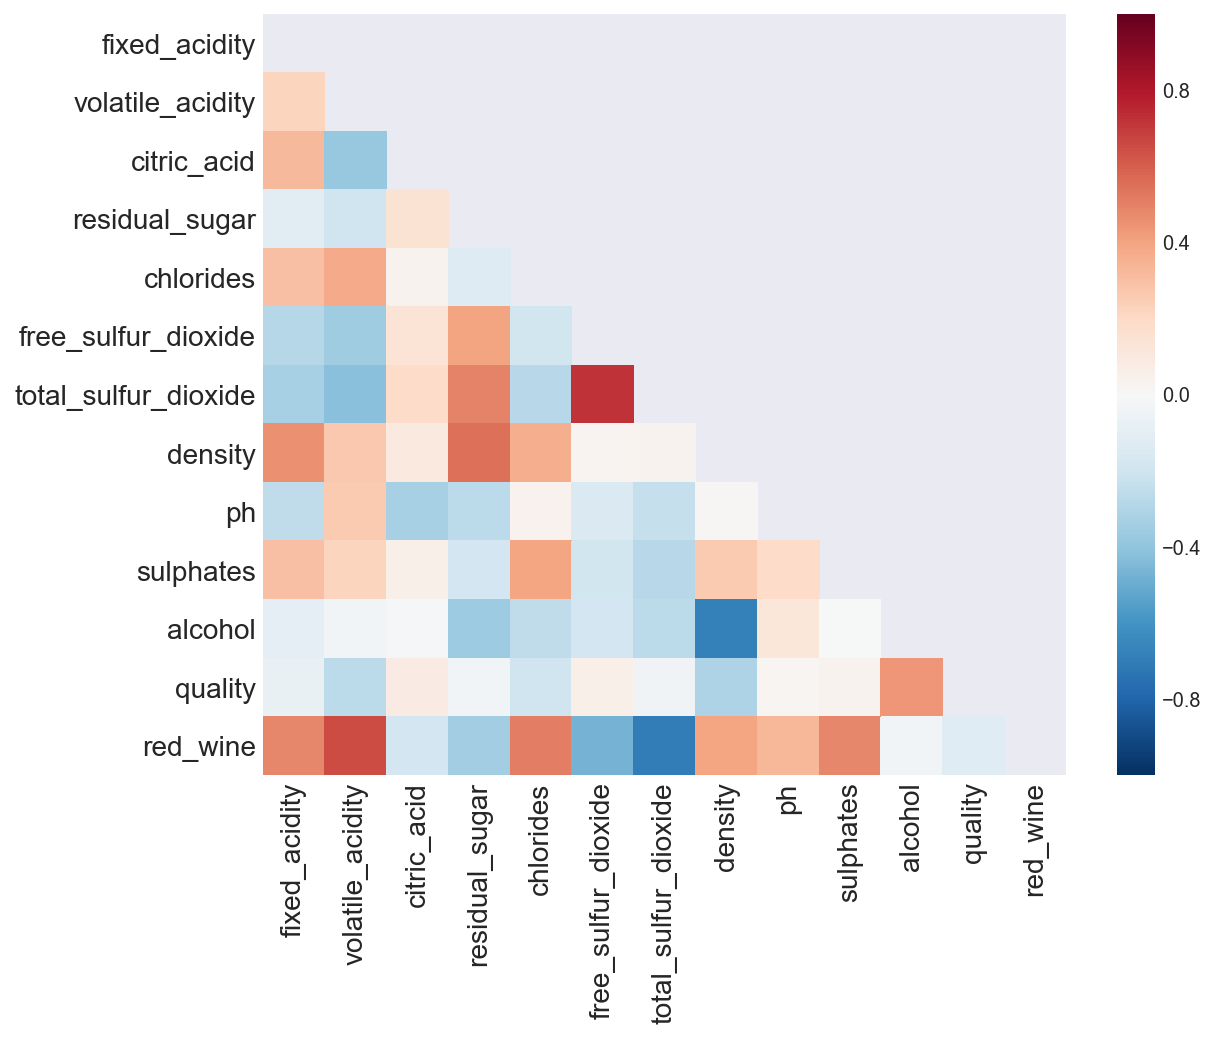

In [6]:
# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(wine_corr, mask=mask, ax=ax, vmin=-1, vmax=1, center=0, cmap="RdBu_r")

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<a id='standardization'></a>

## Standardizing predictors is required

---

With Lasso, it is neccessary to standardize the predictor columns before constructing the models, even the dummy coded categorical variables. 

Below we define our target variable and then normalize the columns that are not the target.

Recall the equation for the Lasso penalty:

### $$ \text{Lasso penalty}\; = \lambda_1\sum_{j=1}^p |\beta_j|$$

**How are the $\beta$ coefficients affected by the mean and variance of your variables?**

If the mean and variance of your $x$ predictors are different, their respective $\beta$ coefficients *scale with the mean and variance of the predictors regardless of their explanatory power.*

This means that if one of your $x$ variables, for example the fixed acidity, will have a much smaller $\beta$ value than say the citric acid – just because the scale of the two variables are so different!

The Lasso penalty do not take into account to the mean and variance of your predictors, so the adjustment is up to you. All they "care about" are the values of the coefficients.

In [7]:
# Choose a target/dependent variable that we will predict
target = 'quality'

In [8]:
wine['quality'].value_counts().sort_index()

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

In [9]:
# select all the columns that are not the target
features_columns = [x for x in wine.columns if x != target]

In [10]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


- We will use the Standarscaler on wine to standarize your target variables.

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()
X = wine[features_columns]
y = wine['quality']
Xss = scaler.fit_transform(X)
Xss = pd.DataFrame(Xss, index=X.index, columns=X.columns)
Xss.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,red_wine
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,1.75019
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,1.75019
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,1.75019
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,1.75019
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,1.75019


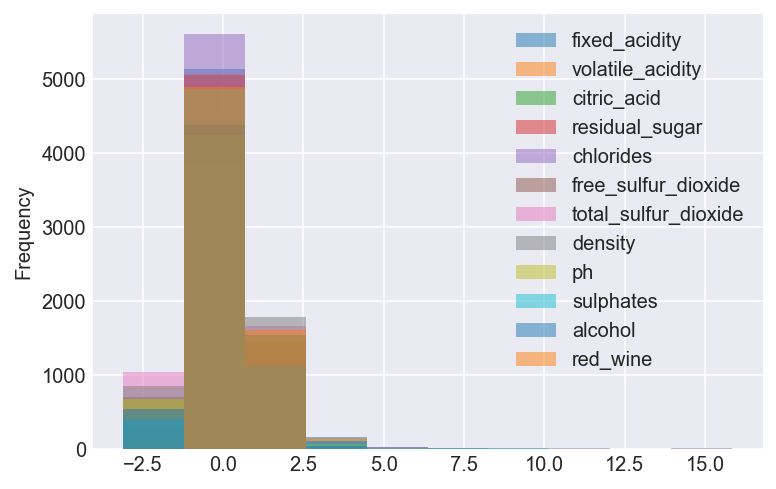

In [13]:
Xss.plot(kind="hist", alpha=0.5)

In [14]:
wine_ss = pd.concat([y, Xss], axis=1)
wine_ss.head()

,quality,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,red_wine
0,5,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,1.75019
1,5,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,1.75019
2,5,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,1.75019
3,6,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,1.75019
4,5,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,1.75019


### Creating the target and predictor matrix with helper functions (Patsy).

**Note**: [Patsy](https://patsy.readthedocs.io/en/latest/) its a library used to describe statistical models in Python. It's helpful for creating new feature matrices quickly. The use of Patsy in your projects is **completely optional**.

We will be making two X, Y datasets. One of them will be dramatically more complex, with lots of collinearity (and thus will make our model overfit).

1. The first is going to just be all the variables added together.
2. The second will have all interactions between the variables included. This should overfit the target quite a bit!


In [15]:
import patsy

# Get the non-target cols with a simple list comprehension
non_target_cols = [c for c in wine_ss.columns if c != target]

# Use some string adding and joining to make the simple model formula:
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print( "Simple formula: \n")
print( formula_simple)
print( "\n")
# Make the complex formula:
formula_complex = target + ' ~ (' + ' + '.join(non_target_cols) + ')**2 -1'
print( "Complex formula: \n")
print( formula_complex)

# Create the X and Y pairs for both!
y, X = patsy.dmatrices(formula_simple, data=wine_ss, return_type='dataframe')
yoverfit, Xoverfit = patsy.dmatrices(formula_complex, data=wine_ss, return_type='dataframe')

y = y.values.ravel()
yoverfit = yoverfit.values.ravel()


Simple formula: 

quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ph + sulphates + alcohol + red_wine -1


Complex formula: 

quality ~ (fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ph + sulphates + alcohol + red_wine)**2 -1


**Look at how the shapes of the X matrices differ. You can see that the Xoverfit has considerably more columns due to the creation of all possible two-way interactions.**

In [16]:
print( X.shape)
print( Xoverfit.shape) # check that now we have more columns

(6497, 12)
(6497, 78)


We can plot the heatmap of the new, extended, feature matrix, and check that there's a lot of collinearity

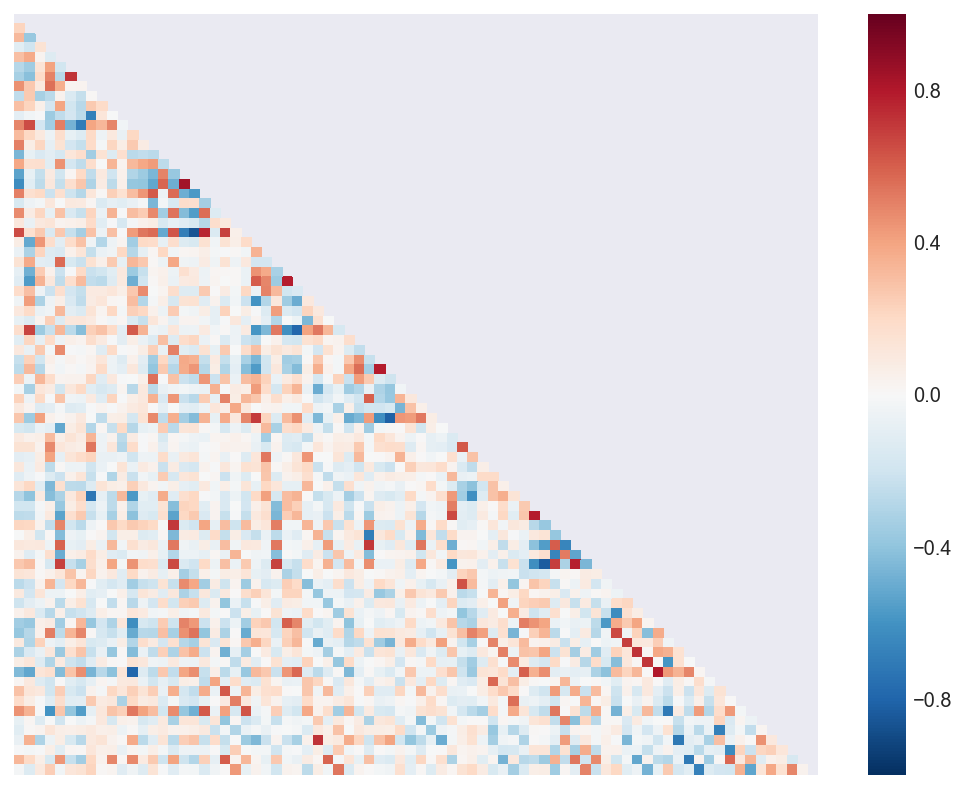

In [17]:
# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(Xoverfit.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(Xoverfit.corr(), mask=mask, ax=ax, vmin=-1, vmax=1, center=0, cmap="RdBu_r")

# Resize the labels.
ax.set_xticklabels("")
ax.set_yticklabels("")

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<a id='viz-ridge'></a>

## Visualizing the Lasso

---

Import the `Lasso` model class from sklearn.

**Note**: For solving regression problems we need to import Lasso, which extends Linear Regression. For classification problems, the LogisticRegression class has the inbuilt option of using a lasso penalty.

In [18]:
from sklearn.linear_model import Lasso

This function iterates over a series of different alpha regularization parameters. **The alpha is sklearn's equivalent of the lambda value in the formula that multiples the square of betas from the equation.**

The function stores the results of the model so that we can plot them interactively.

In [19]:
# This is the same as the ridge coefficient by alpha calculator
def lasso_coefs(X, Y, alphas):
    coefs = []
    lasso_reg = Lasso()
    for a in alphas:
        lasso_reg.set_params(alpha=a) # We set the hyperparameter alpha
        lasso_reg.fit(X, Y)
        coefs.append(lasso_reg.coef_)
        
    return coefs

In [20]:
l_alphas = np.arange(0.01, 0.15, 0.0025)
l_coefs = lasso_coefs(Xoverfit, y, l_alphas)

In [21]:
len(l_alphas)

56

In [22]:
len(l_coefs)

56

The plotting function below will:

 - Plot the effect of changing alpha on the coefficient size on a **path** graph
 - Plot the effect of changing alpha on the coefficient size on a **bar** graph
 
Each one gives informative information. It's just two different ways of visualizing the same thing. The chart is interactive so you can play around with the values of alpha across the specified range above.

In [23]:
# The cycler package lets us "cycle" throug colors.
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,5)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2)
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(range(1, len(feature_names)+1), coefs[-1], align='center', color=colors) #TODO
    ax2.set_xticks(range(1, len(feature_names)+1))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()


Load the ipython widgets so we can make this plotting function interactive!

In [24]:
from ipywidgets import *
from IPython.display import display

The function and `interact` from ipywidgets lets me take some specified alphas that we have already calculated the coefficients for and plot them out.

In [25]:
def lasso_plot_runner(alpha=0):
    coef_plotter(l_alphas, l_coefs, Xoverfit.columns, alpha, regtype='lasso')

interact(lasso_plot_runner, alpha=(0.01, 0.15, 0.0025))

interactive(children=(FloatSlider(value=0.01, description='alpha', max=0.15, min=0.01, step=0.0025), Output()), _dom_classes=('widget-interact',))

<function __main__.lasso_plot_runner>

## Note on choosing a range of values for alpha:

The range of possible values for lambda/alpha can go from zero to infinity. There's no clear cut answer for the best possible values, as they will depend on the number of features and their collinearity. 

In practice, try to start small and build it up. Which means that if you see your test metrics still improving at the right side of your range of values, then you might need to extend the range and search for bigger alphas.

<a id='model-performance'></a>

## Model performance of Lasso on the overfit data

---

Let's check out how the penalties affect the performance of our models. On the basic wine dataset there won't be much benefit to using regularization. We can switch over to the overfit data instead to see if regularization helps us control overfitting.

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [27]:
def lasso_cv_rmse(X, y, l_alphas):
    lasso_rmse = []

    # initialize model
    lasso = Lasso()
    # iterate through Lasso alphas
    for la in l_alphas:
        
        # set the current alpha to the model
        lasso.set_params(alpha=la)
        
        # keep track of fold RMSE        
        lasso_scores = cross_val_score(lasso, X, y, scoring="neg_mean_squared_error")
        lasso_rmse.append( np.sqrt(np.mean(-1 * lasso_scores)) )
                    
    # We can compared against a multiple linear regression without regularisation
    linreg = LinearRegression()
    
    linreg_scores = cross_val_score(linreg, X, y, scoring="neg_mean_squared_error")
    linreg_rmse = np.sqrt(np.mean(-1 * linreg_scores))

                                    
    return lasso_rmse, linreg_rmse
    
# Get the lasso cross-validated RMSE for the overfitted and the simple dataset:
lasso_rmse, linreg_rmse = lasso_cv_rmse(Xoverfit, yoverfit, l_alphas)
lasso_rmse_simple, linreg_rmse_simple = lasso_cv_rmse(X, y, l_alphas)


In [28]:
print( "Best Lasso score for the feature matrix with high collinearity: " + str(min(lasso_rmse)))
print( "Best Linear Regression score for the feature matrix with high collinearity: " + str(linreg_rmse))

Best Lasso score for the feature matrix with high collinearity: 0.75967046359
Best Linear Regression score for the feature matrix with high collinearity: 7.11196518494e+12


In [29]:
print( "Best Lasso score for the original (standarized) feature matrix: " + str(min(lasso_rmse_simple)))
print( "Best Linear Regression score for the original (standarized) feature matrix: " + str(linreg_rmse_simple))

Best Lasso score for the original (standarized) feature matrix: 0.756755770743
Best Linear Regression score for the original (standarized) feature matrix: 0.847398035383


Below we have a new plotting function that will track the performance of the model as the alphas increase, as measured by the RMSE across cross-validation folds.

In [30]:
def rmse_plotter(lasso_alphas, lasso_to_alpha, lasso_rmse, linreg_rmse_simple):
    
    lasso_amin = np.min(lasso_alphas)
    lasso_amax = np.max(lasso_alphas)
    
    # Subet the models' alphas and rsqs according to the currently set
    # alpha limits for each (passed in from the interactive sliders)
    
    lasso_alphas = [a for a in lasso_alphas if a <= lasso_to_alpha]
    lasso_rmse = lasso_rmse[0:len(lasso_alphas)]
    
    # Get some unique colors out for the Ridge R2 line, Lasso R2 line,
    # Enet R2, and the 'max R2 achieved' line.
    colors = sns.xkcd_palette(['windows blue', 'amber', 'dark red', 'faded green'])

    # We will again be plotting two axes on the same figure:
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # The first subplot axes is for the ridge
    ax1 = fig.add_subplot(131)
    
    # Plot a vertical line indicating the current alpha selected
    ax1.axvline(lasso_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot a horizontal line for the vanilla linear regression RMSE
    ax1.axhline(linreg_rmse, lw=2, c=colors[2], alpha=0.8)
    
    # Plot the line tracking RMSE by alpha values
    ax1.plot(lasso_alphas, lasso_rmse, lw=3, c=colors[0])
    
    # Add the axis labels
    ax1.set_xlabel('lasso alpha', fontsize=20)
    ax1.set_ylabel('lasso CV RMSE', fontsize=20)
        
    # Fix the axes in place
    ax1.set_xlim([lasso_amin, lasso_amax])
    ax1.set_ylim([-0.05, 1])
    
    # set the title for the axes;
    ax1.set_title('lasso cross-val performance\n', fontsize=20)
    
    plt.show()

In [31]:
# We have our new widget where you can change both the Ridge and Lasso alphas to see how they compare:
def rmse_plot_pipe(la):
    rmse_plotter(l_alphas, la, lasso_rmse_simple, linreg_rmse_simple)
    
w = widgets.interactive(rmse_plot_pipe, 
                        la=widgets.FloatSlider(value=0, min=0., max=0.2, step=0.0025, description='Lasso alpha:'),
)

display(w)

interactive(children=(FloatSlider(value=0.0, description='Lasso alpha:', max=0.2, step=0.0025), Output()), _dom_classes=('widget-interact',))